In [1]:
#tratamentos iniciais
import pandas as pd
import numpy as np
#divisão dos dados
from sklearn.model_selection import train_test_split
#modelos baseline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score
#text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
# from nltk.tokenize import sent_tokenize (Tokenization)
from nltk.probability import FreqDist
from nltk.metrics import ConfusionMatrix
#visualização 
from wordcloud import WordCloud
import random
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('..\datasets\mouse.csv')

In [4]:
df.head()

,score,description,date
0,"1,0",O produto aparece usado...em baixo do aparelho...,13 de novembro de 2019
1,"5,0","Mouse sem fio ótimo, sem delay, nano receptor ...",19 de agosto de 2019
2,"3,0","A construção do mouse em si é boa, os clicks s...",15 de março de 2019
3,"5,0",A mídia não pôde ser carregada.\n ...,31 de julho de 2020
4,"1,0","O mouse está em boas condições, funcionando be...",21 de junho de 2020


# Pre-processing

### Contagem e remoção de dados nulos

In [5]:
df.isnull().sum()

score           0
description    18
date            0
dtype: int64

In [6]:
df.dropna(axis=0,inplace=True)

### Definição das categorias

In [7]:
def categoriza(dados):
    scores = []
    i = 0
    for dado in dados:
        if (dado == '1,0' or dado == '2,0'):
            scores.append(0)  #avaliação ruim
        if (dado =='3,0'):
            scores.append(1)  #avaliação ruim        
        if (dado == '4,0' or dado == '5,0'):
            scores.append(2) #avaliação boa
        i+=1
    return(scores)

In [8]:
df['score'] = categoriza(df['score'])

In [9]:
df

,score,description,date
0,0,O produto aparece usado...em baixo do aparelho...,13 de novembro de 2019
1,2,"Mouse sem fio ótimo, sem delay, nano receptor ...",19 de agosto de 2019
2,1,"A construção do mouse em si é boa, os clicks s...",15 de março de 2019
3,2,A mídia não pôde ser carregada.\n ...,31 de julho de 2020
4,0,"O mouse está em boas condições, funcionando be...",21 de junho de 2020
...,...,...,...
4812,2,A mídia não pôde ser carregada.,25 de março de 2022
4813,2,"ele é um pouco pequeno, mas tem uma resposta r...",23 de março de 2022
4814,2,"logitech né?! sem comentários, mouse maravilhoso",21 de março de 2022
4815,2,Muito bom e bonito,17 de janeiro de 2022


### Divisão dos dados

In [10]:
y = df['score']
x = df.iloc[:,1]

#divisão do treino e teste

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42,stratify=y)

In [11]:
y_train.value_counts()

2    3634
0     137
1      69
Name: score, dtype: int64

In [12]:
y_test.value_counts()

2    908
0     34
1     18
Name: score, dtype: int64

### Resolvendo o desbalanceamento dos dados de treino

In [13]:
from imblearn.over_sampling import RandomOverSampler

In [14]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))

In [15]:
print(X_resampled.shape)
print(y_resampled.shape)
print('\n',pd.DataFrame(y_resampled).value_counts())

(10902, 1)
(10902,)

 0    3634
1    3634
2    3634
dtype: int64


In [16]:
X_train , y_train = pd.DataFrame(X_resampled), y_resampled

In [17]:
X_train = np.array(X_train[0])

### Tokenização

In [18]:
def tokenizador(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [19]:
X_train = tokenizador(X_train)
X_test = tokenizador(X_test)

### Padronização de algumas escritas

In [20]:
def padroniza_caracteres(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [21]:
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também',
            'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo',
            'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [22]:
X_train = padroniza_caracteres(X_train,std_list)
X_test = padroniza_caracteres(X_test,std_list)

### Remoção de stop words

In [23]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\efvs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
nltk_stopwords = nltk.corpus.stopwords.words('portuguese')

In [25]:
pontos = ['!','.',',',':',';']

for sinal in pontos:
    nltk_stopwords.append(sinal)

In [26]:
nltk_stopwords

['de',
 'a',
 'o',
 'que',
 'e',
 'é',
 'do',
 'da',
 'em',
 'um',
 'para',
 'com',
 'não',
 'uma',
 'os',
 'no',
 'se',
 'na',
 'por',
 'mais',
 'as',
 'dos',
 'como',
 'mas',
 'ao',
 'ele',
 'das',
 'à',
 'seu',
 'sua',
 'ou',
 'quando',
 'muito',
 'nos',
 'já',
 'eu',
 'também',
 'só',
 'pelo',
 'pela',
 'até',
 'isso',
 'ela',
 'entre',
 'depois',
 'sem',
 'mesmo',
 'aos',
 'seus',
 'quem',
 'nas',
 'me',
 'esse',
 'eles',
 'você',
 'essa',
 'num',
 'nem',
 'suas',
 'meu',
 'às',
 'minha',
 'numa',
 'pelos',
 'elas',
 'qual',
 'nós',
 'lhe',
 'deles',
 'essas',
 'esses',
 'pelas',
 'este',
 'dele',
 'tu',
 'te',
 'vocês',
 'vos',
 'lhes',
 'meus',
 'minhas',
 'teu',
 'tua',
 'teus',
 'tuas',
 'nosso',
 'nossa',
 'nossos',
 'nossas',
 'dela',
 'delas',
 'esta',
 'estes',
 'estas',
 'aquele',
 'aquela',
 'aqueles',
 'aquelas',
 'isto',
 'aquilo',
 'estou',
 'está',
 'estamos',
 'estão',
 'estive',
 'esteve',
 'estivemos',
 'estiveram',
 'estava',
 'estávamos',
 'estavam',
 'estivera'

In [27]:
def removedor_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [28]:
X_train = removedor_stopwords(X_train, nltk_stopwords)
X_test = removedor_stopwords(X_test, nltk_stopwords)

# Stemmer

In [29]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\efvs\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [30]:
def aplica_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [31]:
X_train_stem = aplica_stemmer(X_train)
X_test_stem = aplica_stemmer(X_test)

### Visualizações iniciais

In [32]:
def texto_para_cloud(tokens):
    text = ''

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            text += word + ' '
        
    return text

In [33]:
x2=tokenizador(x)

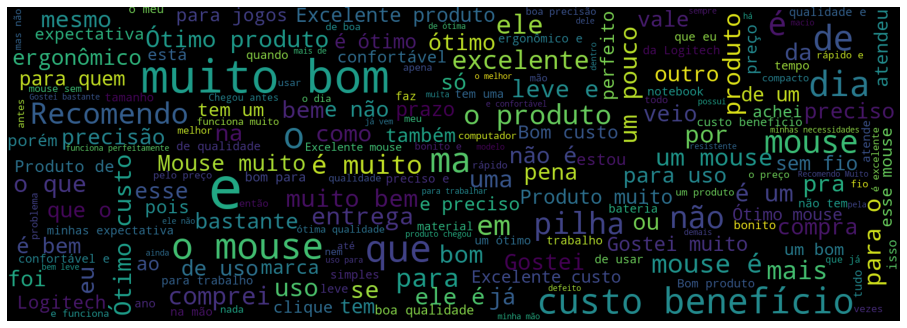

In [34]:
text_cloud = texto_para_cloud(random.sample(x2, 3000))

word_cloud = WordCloud(max_font_size = 100, width = 1520, height = 535)
word_cloud.generate(text_cloud)
plt.figure(figsize = (16, 9))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Frequencias

In [35]:
def pega_freq(tokens):
    ls = []

    for tk_line in tokens:
        for word in tk_line:
            ls.append(word)

    return ls

In [36]:
# Frequency Distribution on training dataset
fd_list = pega_freq(X_train_stem)
fdist = FreqDist(fd_list)
print(fdist)

# most common words
most_common = fdist.most_common(25)
print(most_common,'\n')

<FreqDist with 2288 samples and 162845 outcomes>
[('mous', 6590), ('produt', 3720), ('compr', 2802), ('bom', 2415), ('uso', 2387), ('bem', 1876), ('precis', 1754), ('funcion', 1685), ('vei', 1415), ('func', 1318), ('marc', 1264), ('dia', 1262), ('pilh', 1238), ('mes', 1189), ('problem', 1178), ('us', 1161), ('gost', 1151), ('rol', 1067), ('pouc', 1052), ('pra', 1039), ('ótim', 998), ('scroll', 991), ('(', 990), ('defeit', 988), ('outr', 950)] 



In [37]:
most_uncommon = fdist.hapaxes()
print(most_uncommon[0:30])

['rt', 'gratific', 'aloj', 'ergônom', 'dhl', 'facíl', 'aaaa', 'daí', 'lasq', 'beste', 'recompens', '.,', 'ninguém', 'minuscul', 'típic', 'desemprenh', 'afim', 'tem', 'curvat', 'reflet', 'necessari', 'nan', 'seleç', 'honr', 'vlw', 'ultim', 'empenh', 'cãibr', 'crianç', 'net']


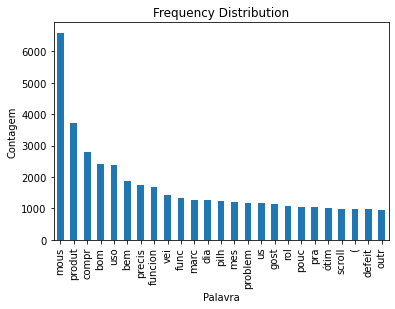

In [38]:
# print most common words
series = pd.Series(data=[v for k, v in most_common], index=[k for k, v in most_common], name='')
ax = series.plot(kind='bar', title='Frequency Distribution')
ax.set_xlabel('Palavra')
ax.set_ylabel('Contagem')
plt.show()

# Destransformando
- Após o tratamento dos dados, com o uso do nltk, voltaremos os mesmos para o formato inicial, de string

In [39]:
def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [40]:
X_train = _untokenize_text(X_train)
X_test = _untokenize_text(X_test)

In [41]:
X_train_stem = _untokenize_text(X_train_stem)
X_test_stem = _untokenize_text(X_test_stem)

## Baseline - Bag of words/Naive Bayes

In [42]:
vetores = CountVectorizer()
#vetores2 = CountVectorizer()

In [43]:
X_train = vetores.fit_transform(X_train)
X_train = X_train.toarray()

In [44]:
X_test = vetores.transform(X_test)
X_test =  X_test.toarray()

print(X_train.shape)
print(X_test.shape)

(10902, 3736)
(960, 3736)


In [45]:
print(X_train.shape)
print(X_test.shape)

(10902, 3736)
(960, 3736)


In [46]:
modelo_1 = MultinomialNB()
modelo_1.fit(X_train,y_train)

MultinomialNB()

In [47]:
predict = modelo_1.predict(X_test)

In [48]:
metrics.accuracy_score(predict, y_test)

0.9229166666666667

In [49]:
test = ['Melhor mouse do brasil',
       'Péssimo mouse horrivel',
       'mais ou menos, mas dá pra usar',
       'compensa, entrega o que promete, mas nada muito além disso']

In [50]:
test = tokenizador(test)
test = padroniza_caracteres(test, std_list)
test = removedor_stopwords(test,nltk_stopwords)
test = _untokenize_text(test)

In [51]:
vetor_test = vetores.transform(test)
vetor_test = vetor_test.toarray()

In [52]:
vetor_test.shape

(4, 3736)

In [53]:
modelo_1.predict(vetor_test)

array([2, 0, 0, 2], dtype=int64)

In [54]:
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.46      0.53      0.49        34
           1       0.07      0.11      0.09        18
           2       0.97      0.95      0.96       908

    accuracy                           0.92       960
   macro avg       0.50      0.53      0.51       960
weighted avg       0.94      0.92      0.93       960



In [55]:
resultados = cross_val_score(modelo_1, X_train, y_train, cv = 10)

In [56]:
print(resultados)

[0.96700275 0.9532539  0.95504587 0.96146789 0.96238532 0.95137615
 0.9559633  0.95779817 0.95137615 0.96238532]


## Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100)

In [58]:
forest.fit(X_train,y_train)

RandomForestClassifier()

In [59]:
print(metrics.classification_report(y_test,forest.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.29      0.42        34
           1       0.00      0.00      0.00        18
           2       0.96      1.00      0.98       908

    accuracy                           0.95       960
   macro avg       0.56      0.43      0.46       960
weighted avg       0.93      0.95      0.94       960



In [ ]:
(98+0+34)/3